In [3]:
import keras

import PIL.ImageFilter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from glob import glob
from keras.preprocessing.image import load_img, img_to_array
import multiprocessing as mp 
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from huggingface_hub import from_pretrained_keras
from PIL import ImageFilter, ImageEnhance
import seaborn as sns

np.random.seed(42)

def load_data(files, start=0, end=10, augment_fn = None): #same accuracy for 90,180, 270 rotation
    X = []
    y = []
    for f in files[start:end]:
        img = load_img(f, target_size=(50, 50))
        print(f'process file {f}')
        if augment_fn is not None:
            sample = augment_fn(img)
        else:    
            sample = tf.convert_to_tensor(img)
        X.append(sample)
        y.append(f[-5])
    return np.array(files[start:end]), np.stack(X), np.array(y, dtype=float)

2023-12-08 10:58:24.903450: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-08 10:58:24.905167: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-08 10:58:24.928843: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-08 10:58:24.928871: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-08 10:58:24.929478: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [4]:
result = pd.read_csv('all_outputs.csv')
files = result['# file']
n = 1000
sample = np.random.randint(0, len(files), n)
sample_files = files[sample]
sample_true_y = result.iloc[sample]['true_y']

bc_model = keras.models.load_model("../models/CanDetect.keras")

In [5]:
_, x, _ = load_data(sample_files, start=0, end=len(files))
predictions_logits = bc_model.predict(x)
predictions_clss = np.where(predictions_logits > 0.5, 1, 0)

print(confusion_matrix(sample_true_y, predictions_clss))
print(accuracy_score(sample_true_y, predictions_clss))

process file ../data/12820/0/12820_idx5_x1951_y1351_class0.png
process file ../data/10305/0/10305_idx5_x2251_y1901_class0.png
process file ../data/16553/0/16553_idx5_x1401_y601_class0.png
process file ../data/10275/0/10275_idx5_x2101_y351_class0.png
process file ../data/15902/1/15902_idx5_x2801_y1651_class1.png
process file ../data/9323/0/9323_idx5_x2301_y1401_class0.png
process file ../data/12873/1/12873_idx5_x1601_y851_class1.png
process file ../data/15516/1/15516_idx5_x1801_y1401_class1.png
process file ../data/13693/0/13693_idx5_x2801_y2301_class0.png
process file ../data/13459/0/13459_idx5_x2301_y1051_class0.png
process file ../data/12947/0/12947_idx5_x3001_y1301_class0.png
process file ../data/9177/0/9177_idx5_x2151_y551_class0.png
process file ../data/9257/1/9257_idx5_x2001_y851_class1.png
process file ../data/8914/0/8914_idx5_x2951_y2901_class0.png
process file ../data/14305/1/14305_idx5_x1401_y501_class1.png
process file ../data/9345/0/9345_idx5_x1351_y1751_class0.png
process 

process file ../data/12820/0/12820_idx5_x1951_y1351_class0.png
process file ../data/10305/0/10305_idx5_x2251_y1901_class0.png
process file ../data/16553/0/16553_idx5_x1401_y601_class0.png
process file ../data/10275/0/10275_idx5_x2101_y351_class0.png
process file ../data/15902/1/15902_idx5_x2801_y1651_class1.png
process file ../data/9323/0/9323_idx5_x2301_y1401_class0.png
process file ../data/12873/1/12873_idx5_x1601_y851_class1.png
process file ../data/15516/1/15516_idx5_x1801_y1401_class1.png
process file ../data/13693/0/13693_idx5_x2801_y2301_class0.png
process file ../data/13459/0/13459_idx5_x2301_y1051_class0.png
process file ../data/12947/0/12947_idx5_x3001_y1301_class0.png
process file ../data/9177/0/9177_idx5_x2151_y551_class0.png
process file ../data/9257/1/9257_idx5_x2001_y851_class1.png
process file ../data/8914/0/8914_idx5_x2951_y2901_class0.png
process file ../data/14305/1/14305_idx5_x1401_y501_class1.png
process file ../data/9345/0/9345_idx5_x1351_y1751_class0.png
process 

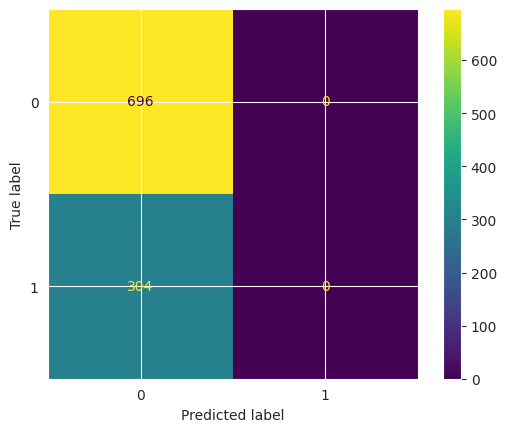

In [6]:
def to_gray_scale(img):
    gs_img = img.convert("L")
    t = tf.convert_to_tensor(gs_img)
    t = tf.stack([t, t, t], axis=-1)
    return t

_, x, _ = load_data(sample_files, start=0, end=len(files), augment_fn=to_gray_scale)
predictions_logits = bc_model.predict(x)
predictions_clss = np.where(predictions_logits > 0.5, 1, 0)

print(confusion_matrix(sample_true_y, predictions_clss))
print(accuracy_score(sample_true_y, predictions_clss))

cm = confusion_matrix(sample_true_y, predictions_clss)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
print(accuracy_score(sample_true_y, predictions_clss))

In [7]:
def to_darker(img):
    enhancer = ImageEnhance.Brightness(img)
    img = enhancer.enhance(0.5)
    t = tf.convert_to_tensor(img)
    return t

_, x, _ = load_data(sample_files, start=0, end=len(files), augment_fn=to_darker)
predictions_logits = bc_model.predict(x)
predictions_clss = np.where(predictions_logits > 0.5, 1, 0)

print(confusion_matrix(sample_true_y, predictions_clss))
print(accuracy_score(sample_true_y, predictions_clss))

process file ../data/12820/0/12820_idx5_x1951_y1351_class0.png
process file ../data/10305/0/10305_idx5_x2251_y1901_class0.png
process file ../data/16553/0/16553_idx5_x1401_y601_class0.png
process file ../data/10275/0/10275_idx5_x2101_y351_class0.png
process file ../data/15902/1/15902_idx5_x2801_y1651_class1.png
process file ../data/9323/0/9323_idx5_x2301_y1401_class0.png
process file ../data/12873/1/12873_idx5_x1601_y851_class1.png
process file ../data/15516/1/15516_idx5_x1801_y1401_class1.png
process file ../data/13693/0/13693_idx5_x2801_y2301_class0.png
process file ../data/13459/0/13459_idx5_x2301_y1051_class0.png
process file ../data/12947/0/12947_idx5_x3001_y1301_class0.png
process file ../data/9177/0/9177_idx5_x2151_y551_class0.png
process file ../data/9257/1/9257_idx5_x2001_y851_class1.png
process file ../data/8914/0/8914_idx5_x2951_y2901_class0.png
process file ../data/14305/1/14305_idx5_x1401_y501_class1.png
process file ../data/9345/0/9345_idx5_x1351_y1751_class0.png
process 

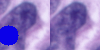

In [20]:
i = 520
im1 = gt.crop((i,i, i +50, i+50))
im2 = test.crop((i, i, i+50, i+50))

Image.fromarray(np.hstack((np.array(im1),np.array(im2))))

In [8]:
def adjust_brightness(factor):
    def adjuster(img):    
        enhancer = ImageEnhance.Brightness(img)
        img = enhancer.enhance(factor)
        t = tf.convert_to_tensor(img)
        return t
    return adjuster

brightness = np.linspace(0.5, 1.5, 11)
accuracies = []

for factor in brightness:
    _, x, _ = load_data(sample_files, start=0, end=len(files), augment_fn=adjust_brightness(factor))
    predictions_logits = bc_model.predict(x)
    predictions_clss = np.where(predictions_logits > 0.5, 1, 0)
    acc = accuracy_score(sample_true_y, predictions_clss)
    print(acc)
    accuracies.append(acc)    

process file ../data/12820/0/12820_idx5_x1951_y1351_class0.png
process file ../data/10305/0/10305_idx5_x2251_y1901_class0.png
process file ../data/16553/0/16553_idx5_x1401_y601_class0.png
process file ../data/10275/0/10275_idx5_x2101_y351_class0.png
process file ../data/15902/1/15902_idx5_x2801_y1651_class1.png
process file ../data/9323/0/9323_idx5_x2301_y1401_class0.png
process file ../data/12873/1/12873_idx5_x1601_y851_class1.png
process file ../data/15516/1/15516_idx5_x1801_y1401_class1.png
process file ../data/13693/0/13693_idx5_x2801_y2301_class0.png
process file ../data/13459/0/13459_idx5_x2301_y1051_class0.png
process file ../data/12947/0/12947_idx5_x3001_y1301_class0.png
process file ../data/9177/0/9177_idx5_x2151_y551_class0.png
process file ../data/9257/1/9257_idx5_x2001_y851_class1.png
process file ../data/8914/0/8914_idx5_x2951_y2901_class0.png
process file ../data/14305/1/14305_idx5_x1401_y501_class1.png
process file ../data/9345/0/9345_idx5_x1351_y1751_class0.png
process 

process file ../data/12820/0/12820_idx5_x1951_y1351_class0.png
process file ../data/10305/0/10305_idx5_x2251_y1901_class0.png
process file ../data/16553/0/16553_idx5_x1401_y601_class0.png
process file ../data/10275/0/10275_idx5_x2101_y351_class0.png
process file ../data/15902/1/15902_idx5_x2801_y1651_class1.png
process file ../data/9323/0/9323_idx5_x2301_y1401_class0.png
process file ../data/12873/1/12873_idx5_x1601_y851_class1.png
process file ../data/15516/1/15516_idx5_x1801_y1401_class1.png
process file ../data/13693/0/13693_idx5_x2801_y2301_class0.png
process file ../data/13459/0/13459_idx5_x2301_y1051_class0.png
process file ../data/12947/0/12947_idx5_x3001_y1301_class0.png
process file ../data/9177/0/9177_idx5_x2151_y551_class0.png
process file ../data/9257/1/9257_idx5_x2001_y851_class1.png
process file ../data/8914/0/8914_idx5_x2951_y2901_class0.png
process file ../data/14305/1/14305_idx5_x1401_y501_class1.png
process file ../data/9345/0/9345_idx5_x1351_y1751_class0.png
process 

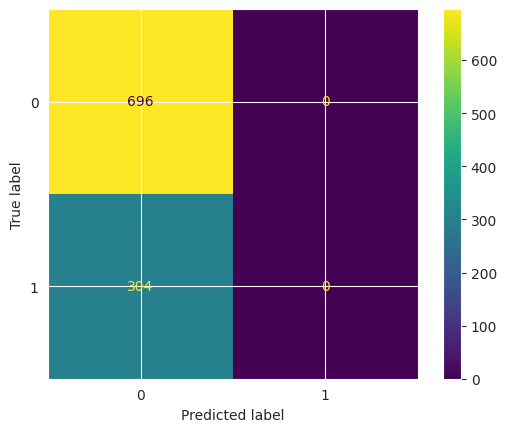

In [9]:
_, x, _ = load_data(sample_files, start=0, end=len(files), augment_fn=adjust_brightness(0.5))
predictions_logits = bc_model.predict(x)
predictions_clss = np.where(predictions_logits > 0.5, 1, 0)

cm = confusion_matrix(sample_true_y, predictions_clss)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
print(accuracy_score(sample_true_y, predictions_clss))

<Axes: xlabel='brightness factor', ylabel='accuracy'>

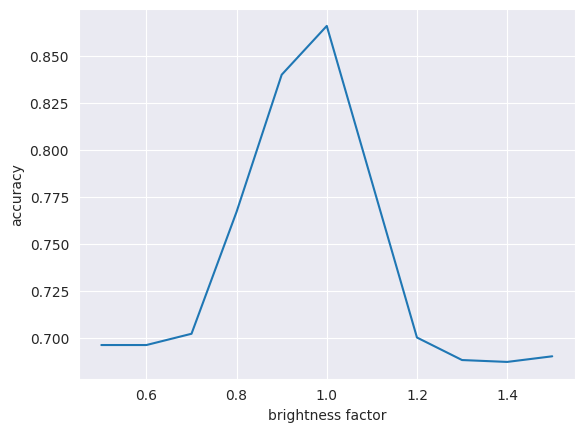

In [10]:
df = pd.DataFrame({'accuracy': accuracies, 'brightness factor': brightness})
sns.lineplot(df, x='brightness factor', y='accuracy')

In [11]:
def get_gaussian_blur_filter(factor):
    def adjuster(img):  
        img = img.filter(ImageFilter.GaussianBlur(factor))
        t = tf.convert_to_tensor(img)
        return t
    return adjuster

sample2 = np.random.randint(0, len(files), 100)
sample_files2 = files[sample2]
sample_true_y2 = result.iloc[sample2]['true_y']

blur = np.linspace(0, 2, 21)
accuracies = []

for factor in blur:
    _, x, _ = load_data(sample_files2, start=0, end=len(files), augment_fn=get_gaussian_blur_filter(factor))
    predictions_logits = bc_model.predict(x)
    predictions_clss = np.where(predictions_logits > 0.5, 1, 0)
    acc = accuracy_score(sample_true_y2, predictions_clss)
    print(acc)
    accuracies.append(acc)    

process file ../data/10261/0/10261_idx5_x1251_y551_class0.png
process file ../data/12901/0/12901_idx5_x2451_y1851_class0.png
process file ../data/12890/0/12890_idx5_x2001_y751_class0.png
process file ../data/9176/0/9176_idx5_x2551_y1501_class0.png
process file ../data/12955/0/12955_idx5_x1501_y2451_class0.png
process file ../data/12826/0/12826_idx5_x3501_y751_class0.png
process file ../data/12934/0/12934_idx5_x2601_y751_class0.png
process file ../data/10257/0/10257_idx5_x1651_y651_class0.png
process file ../data/16533/0/16533_idx5_x1251_y1951_class0.png
process file ../data/12826/0/12826_idx5_x901_y1851_class0.png
process file ../data/13021/0/13021_idx5_x3101_y301_class0.png
process file ../data/12873/1/12873_idx5_x1001_y701_class1.png
process file ../data/13021/0/13021_idx5_x2651_y101_class0.png
process file ../data/13400/0/13400_idx5_x1001_y701_class0.png
process file ../data/8956/0/8956_idx5_x101_y801_class0.png
process file ../data/15472/0/15472_idx5_x1151_y601_class0.png
process f

process file ../data/12820/0/12820_idx5_x1951_y1351_class0.png
process file ../data/10305/0/10305_idx5_x2251_y1901_class0.png
process file ../data/16553/0/16553_idx5_x1401_y601_class0.png
process file ../data/10275/0/10275_idx5_x2101_y351_class0.png
process file ../data/15902/1/15902_idx5_x2801_y1651_class1.png
process file ../data/9323/0/9323_idx5_x2301_y1401_class0.png
process file ../data/12873/1/12873_idx5_x1601_y851_class1.png
process file ../data/15516/1/15516_idx5_x1801_y1401_class1.png
process file ../data/13693/0/13693_idx5_x2801_y2301_class0.png
process file ../data/13459/0/13459_idx5_x2301_y1051_class0.png
process file ../data/12947/0/12947_idx5_x3001_y1301_class0.png
process file ../data/9177/0/9177_idx5_x2151_y551_class0.png
process file ../data/9257/1/9257_idx5_x2001_y851_class1.png
process file ../data/8914/0/8914_idx5_x2951_y2901_class0.png
process file ../data/14305/1/14305_idx5_x1401_y501_class1.png
process file ../data/9345/0/9345_idx5_x1351_y1751_class0.png
process 

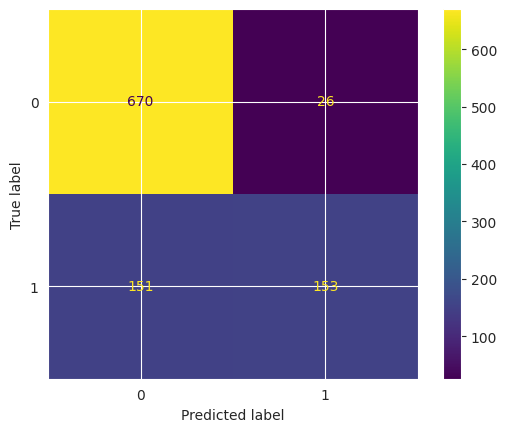

In [12]:
_, x, _ = load_data(sample_files, start=0, end=len(files), augment_fn=get_gaussian_blur_filter(1))
predictions_logits = bc_model.predict(x)
predictions_clss = np.where(predictions_logits > 0.5, 1, 0)

cm = confusion_matrix(sample_true_y, predictions_clss)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
print(accuracy_score(sample_true_y, predictions_clss))

<Axes: xlabel='blur factor', ylabel='accuracy'>

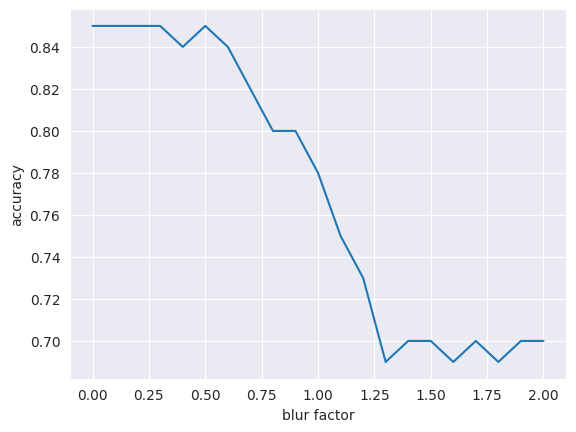

In [13]:
df = pd.DataFrame({'accuracy': accuracies, 'blur factor': blur})
sns.lineplot(df, x='blur factor', y='accuracy')

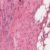

In [14]:
# t = tf.convert_to_tensor(gs_img)
# t = tf.stack([t, t, t], axis=-1)
# t = t[None, :, :, :]
# bc_model.predict(t)
test_img = load_img(sample_files.iloc[2])

from PIL import ImageFilter, ImageEnhance
test_img = test_img.filter(ImageFilter.GaussianBlur(0.5))
test_img


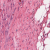

In [15]:
load_img(sample_files.iloc[2])

In [21]:
t = test.crop((i, i, i + 50, i + 50))
t = tf.convert_to_tensor(t)
t = t[None, :, :, :]
bc_model.predict(t)

1/1 [==============================] - 0s 27ms/step


array([[0.35246122]], dtype=float32)

In [16]:
from PIL import Image
#test = Image.open('/home/monika/Moje/ML-sem-III/eml2023/project/original_data_set/BreCaHAD/images/Case_1-01.tif')
test = Image.open('/home/mdrzewiecki/mim/BreastCancerAnalysis/data/images/Case_1-01.tif')

In [17]:
i = 300
preds = []
for i in range(300):
    t = test.crop((i, i, i + 50, i + 50))
    t = tf.convert_to_tensor(t)
    t = t[None, :, :, :]
    preds.append(bc_model.predict(t))

1/1 [==============================] - 0s 25ms/step


(array([155.,  42.,  33.,  19.,  14.,  12.,  11.,   5.,   3.,   6.]),
 array([1.90316568e-04, 6.82432726e-02, 1.36296242e-01, 2.04349190e-01,
        2.72402167e-01, 3.40455115e-01, 4.08508062e-01, 4.76561040e-01,
        5.44614017e-01, 6.12666965e-01, 6.80719912e-01]),
 <BarContainer object of 10 artists>)

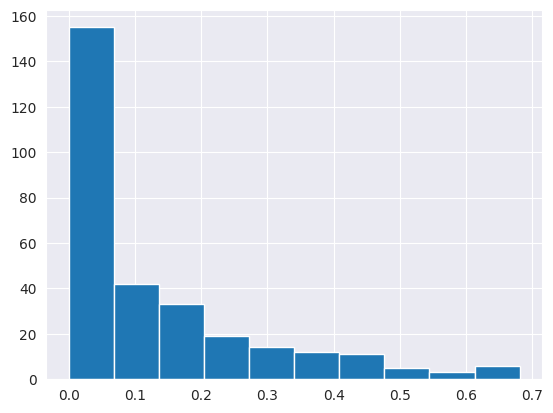

In [18]:
plt.hist([p[0][0] for p in preds])

In [19]:
#gt = Image.open('/home/monika/Moje/ML-sem-III/eml2023/project/original_data_set/BreCaHAD/groundTruth_display/Case_1-01.png')
gt = Image.open('/home/mdrzewiecki/mim/BreastCancerAnalysis/data/groundTruth_display/Case_1-01.png')